# **Init**

In [1]:
# using Pkg; installed = Pkg.installed()
# for p in ("Images", "Colors", "Plots", "IterTools", "PyCall", "Einsum")
#     haskey(installed,p) || Pkg.add(p)
# end

In [2]:
using Pkg
using PyCall
using Knet
using Knet.CUDA
using Knet: atype
using Einsum
@pyimport torch
@pyimport torch.nn as nn

In [3]:
collect(devices())

2-element Vector{CuDevice}:
 CuDevice(0): NVIDIA GeForce RTX 3090
 CuDevice(1): NVIDIA GeForce RTX 3090

In [4]:
device!(0)
device()

CuDevice(0): NVIDIA GeForce RTX 3090

# **Dataset.jl**

In [5]:
using Pkg, Colors, Images, Knet, Statistics, Plots; default(fmt = :png) 
using Base.Iterators: flatten
using IterTools: ncycle, takenth

In [6]:
train_image_paths = split(read(`ls -1v /home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Image`, String));
train_mask_paths = split(read(`ls -1v /home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask`, String));
train_contour_paths = split(read(`ls -1v /home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask`, String));

train_image_paths = ["/home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Image/"*i for i in train_image_paths]
train_mask_paths = ["/home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask/"*i for i in train_mask_paths];
train_contour_paths = ["/home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask/"*i for i in train_contour_paths];


In [7]:
function preprocess_img(instance; imsize=224, random_crop=true, random_flip=true)
    new_img = deepcopy(instance[:,:,1]) # img = 0 at the end?
    new_msk = deepcopy(instance[:,:,2]) # img = 0 at the end?
    new_cnt = deepcopy(instance[:,:,3]) # img = 0 at the end?
    if random_flip
        if rand() > 0.5
            new_img = reverse(new_img, dims=2)
            new_msk = reverse(new_msk, dims=2)
            new_cnt = reverse(new_cnt, dims=2)
        end
    end
    
    if random_crop
        scale_size = 256
        x1 = rand(1: scale_size-imsize)
        y1 = rand(1: scale_size-imsize)
        new_img = new_img[x1:x1+imsize-1, y1:y1+imsize-1]
        new_msk = new_msk[x1:x1+imsize-1, y1:y1+imsize-1]
        new_cnt = new_cnt[x1:x1+imsize-1, y1:y1+imsize-1]
    end
    return new_img, new_msk, new_cnt
end


preprocess_img (generic function with 1 method)

In [8]:
function load_data(img_paths, mask_paths, contour_paths; imsize=224, temp_n = 32)
    images = 0
    labels = 0
    contours = 0
    first = true
    temp_n_samples = 0
    for (path_img, path_msk, path_con) in zip(img_paths, mask_paths, contour_paths)
        if temp_n_samples < temp_n
            temp_n_samples += 1
            img = Images.imresize(load(path_img), 256, 256)
            label = Images.imresize(load(path_msk), 256, 256)
            contour = Images.imresize(load(path_con), 256, 256)
            
            if first
                images = cat(img, dims=4)
                labels = cat(label, dims=3)
                contours = cat(label, dims=3)
                first = false
            else
                images = cat(images, img, dims=4)
                labels = cat(labels, label, dims=3)
                contours = cat(contours, contour, dims=3)
            end
        end
    end
    # gt = permutedims(cat(labels, contours, dims=4), [1,2,4,3]) # GT's are concatenated. Permute required for Knet Minibatch
    gt = cat(labels, contours, dims=4) # GT's are concatenated. Permute required for Knet Minibatch
    return images, permutedims(gt, (1,2,4,3))
end;

In [9]:
dataset_train = load_data(train_image_paths, train_mask_paths, train_contour_paths)
x_train, y_train = dataset_train;

size(x_train), size(y_train)

batch_size = 4
train_data = Knet.minibatch(x_train, y_train, batch_size)

x, y = first(train_data);
imgs = x[:,:,1,:]
msks = y[:,:,1,:]
cnts = y[:,:,2,:]
size(imgs), size(msks), size(cnts)

for i in 1:batch_size
    sample, mask, cont = preprocess_img.(eachslice(cat(imgs, msks, cnts, dims=4), dims=3))[i];   
    mask = channelview(Gray.(mask)) # Convert gt to grayscale
    cont = channelview(Gray.(cont)) # Convert gt to grayscale
    
    println(size(channelview(sample)))
    println(size(mask))
    println(size(cont))
    println()
end

(3, 224, 224)
(224, 224)
(224, 224)

(3, 224, 224)
(224, 224)
(224, 224)

(3, 224, 224)
(224, 224)
(224, 224)

(3, 224, 224)
(224, 224)
(224, 224)



In [10]:
mutable struct LayerNorm; a; b; ϵ; end

function LayerNorm(dmodel; eps=1e-6)
    a = param(dmodel; init=ones)
    b = param(dmodel; init=zeros)
    LayerNorm(a, b, eps)
end

function (l::LayerNorm)(x, o...)
    μ = mean(x,dims=1)
    σ = std(x,mean=μ,dims=1)
    ϵ = eltype(x)(l.ϵ)
    l.a .* (x .- μ) ./ (σ .+ ϵ) .+ l.b # To Do: doing x .- μ twice?
end


mutable struct Linear; w; b; end

function Linear(input::Int,outputs...; bias=true)
    Linear(param(outputs...,input), bias ? param0(outputs...) : nothing)
end

function (l::Linear)(x)
    W1,W2,X1,X2 = size(l.w)[1:end-1], size(l.w)[end], size(x,1), size(x)[2:end]; 
    @assert W2===X1
    y = reshape(l.w,:,W2) * reshape(x,X1,:)
    y = reshape(y, W1..., X2...)
    if l.b !== nothing; y = y .+ l.b; end
    return y
end

# Chain
mutable struct Sequential; layers; end

function Sequential(layer1, layer2, layers...)
    Sequential((layer1, layer2, layers...))
end

function (l::Sequential)(x, o...)
    for layer in l.layers
        x = layer(x, o...)
    end
    return x
end


# using Knet.Layers21: dropout
using Knet.Ops21: dropout

struct Dropout; p; end

function (l::Dropout)(x)        
    dropout(x, l.p)
end
token_transformer
Attention, Token_transformer



LoadError: UndefVarError: token_transformer not defined

In [11]:
using Pkg, Colors, Images, Knet, Statistics, Plots; default(fmt = :png) 
using Base.Iterators: flatten
using IterTools: ncycle, takenth

In [12]:
train_image_paths = split(read(`ls -1v /home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Image`, String));
train_mask_paths = split(read(`ls -1v /home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask`, String));
train_contour_paths = split(read(`ls -1v /home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask`, String));

train_image_paths = ["/home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Image/"*i for i in train_image_paths]
train_mask_paths = ["/home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask/"*i for i in train_mask_paths];
train_contour_paths = ["/home/mertcokelek/Desktop/Github/VST/RGB_VST/Data/DUTS/DUTS-TR/DUTS-TR-Mask/"*i for i in train_contour_paths];

In [13]:
function preprocess_img(instance; imsize=224, random_crop=true, random_flip=true)
    new_img = deepcopy(instance[:,:,1]) # img = 0 at the end?
    new_msk = deepcopy(instance[:,:,2]) # img = 0 at the end?
    new_cnt = deepcopy(instance[:,:,3]) # img = 0 at the end?
    if random_flip
        if rand() > 0.5
            new_img = reverse(new_img, dims=2)
            new_msk = reverse(new_msk, dims=2)
            new_cnt = reverse(new_cnt, dims=2)
        end
    end
    
    if random_crop
        scale_size = 256
        x1 = rand(1: scale_size-imsize)
        y1 = rand(1: scale_size-imsize)
        new_img = new_img[x1:x1+imsize-1, y1:y1+imsize-1]
        new_msk = new_msk[x1:x1+imsize-1, y1:y1+imsize-1]
        new_cnt = new_cnt[x1:x1+imsize-1, y1:y1+imsize-1]
    end
    return new_img, new_msk, new_cnt
end


preprocess_img (generic function with 1 method)

In [14]:
function load_data(img_paths, mask_paths, contour_paths; imsize=224, temp_n = 32)
    images = 0
    labels = 0
    contours = 0
    first = true
    temp_n_samples = 0
    for (path_img, path_msk, path_con) in zip(img_paths, mask_paths, contour_paths)
        if temp_n_samples < temp_n
            temp_n_samples += 1
            img = Images.imresize(load(path_img), 256, 256)
            label = Images.imresize(load(path_msk), 256, 256)
            contour = Images.imresize(load(path_con), 256, 256)
            
            if first
                images = cat(img, dims=4)
                labels = cat(label, dims=3)
                contours = cat(label, dims=3)
                first = false
            else
                images = cat(images, img, dims=4)
                labels = cat(labels, label, dims=3)
                contours = cat(contours, contour, dims=3)
            end
        end
    end
    # gt = permutedims(cat(labels, contours, dims=4), [1,2,4,3]) # GT's are concatenated. Permute required for Knet Minibatch
    gt = cat(labels, contours, dims=4) # GT's are concatenated. Permute required for Knet Minibatch
    return images, permutedims(gt, (1,2,4,3))
end;

In [15]:
dataset_train = load_data(train_image_paths, train_mask_paths, train_contour_paths)
x_train, y_train = dataset_train;


size(x_train), size(y_train)


batch_size = 4
train_data = Knet.minibatch(x_train, y_train, batch_size)


x, y = first(train_data);
imgs = x[:,:,1,:]
msks = y[:,:,1,:]
cnts = y[:,:,2,:]
size(imgs), size(msks), size(cnts)


for i in 1:batch_size
    sample, mask, cont = preprocess_img.(eachslice(cat(imgs, msks, cnts, dims=4), dims=3))[i];   
    mask = channelview(Gray.(mask)) # Convert gt to grayscale
    cont = channelview(Gray.(cont)) # Convert gt to grayscale
    
    println(size(channelview(sample)))
    println(size(mask))
    println(size(cont))
    println()
end

(3, 224, 224)
(224, 224)
(224, 224)

(3, 224, 224)
(224, 224)
(224, 224)

(3, 224, 224)
(224, 224)
(224, 224)

(3, 224, 224)
(224, 224)
(224, 224)



# **Implementation**

## **utils.jl**
**Linear, 
LayerNorm, Sequential, Dropout**

In [16]:
mutable struct LayerNorm; a; b; ϵ; end

function LayerNorm(dmodel; eps=1e-6)
    a = param(dmodel; init=ones)
    b = param(dmodel; init=zeros)
    LayerNorm(a, b, eps)
end

function (l::LayerNorm)(x, o...)
    μ = mean(x,dims=1)
    σ = std(x,mean=μ,dims=1)
    ϵ = eltype(x)(l.ϵ)
    l.a .* (x .- μ) ./ (σ .+ ϵ) .+ l.b # To Do: doing x .- μ twice?
end


mutable struct Linear; w; b; end

function Linear(input::Int,outputs...; bias=true)
    Linear(param(outputs...,input), bias ? param0(outputs...) : nothing)
end

function (l::Linear)(x)
    W1,W2,X1,X2 = size(l.w)[1:end-1], size(l.w)[end], size(x,1), size(x)[2:end]; 
    @assert W2===X1
    y = reshape(l.w,:,W2) * reshape(x,X1,:)
    y = reshape(y, W1..., X2...)
    if l.b !== nothing; y = y .+ l.b; end
    return y
end

# Chain
mutable struct Sequential; layers; end

function Sequential(layer1, layer2, layers...)
    Sequential((layer1, layer2, layers...))
end

function (l::Sequential)(x, o...)
    for layer in l.layers
        x = layer(x, o...)
    end
    return x
end


# using Knet.Layers21: dropout
using Knet.Ops21: dropout

struct Dropout; p; end

function (l::Dropout)(x)        
    dropout(x, l.p)
end

## **token_transformer.jl**
**Attention, Token_transformer**

In [62]:
mutable struct Attention
    dim; num_heads; in_dim; qkv_bias; qk_scale; attn_drop; proj_drop;
    
    scale; qkv; proj;
    function Attention(;dim=784, in_dim=0, num_heads=8, qkv_bias=false, qk_scale=false, attn_drop=0., proj_drop=0.)
        self = new(dim, num_heads, qkv_bias, qk_scale, attn_drop, proj_drop)
        self.num_heads = num_heads
        self.in_dim = in_dim
        
        head_dim = dim ÷ num_heads
        
        self.scale = qk_scale || head_dim^-0.5
        
        # Seperating qkv.
        self.qkv = Linear(dim, in_dim*3, bias=qkv_bias)
        
        # self.q = Linear(dim, in_dim, bias=qkv_bias)
        # self.k = Linear(dim, in_dim, bias=qkv_bias)
        # self.v = Linear(dim, in_dim, bias=qkv_bias)
        
        self.attn_drop = Dropout(attn_drop)

        self.proj = Linear(in_dim, in_dim)
        self.proj_drop = Dropout(proj_drop)
        return self
    end
end


function(self::Attention)(x)
    B, N, C = size(x)
    
    qkv = permutedims(reshape(self.qkv(x), (B, N, 3, self.num_heads, self.in_dim)), (3,1,4,2,5)) # Old (VST PyTorch implementation) Merged QKV. 
    q, k, v = qkv[1], qkv[2], qkv[3]
    # q, k, v = qkv[1,:,:,:,:], qkv[2,:,:,:,:], qkv[3,:,:,:,:]

    # q = permutedims(reshape(self.q(x), (B, N, 1, self.num_heads, self.in_dim)), (3,1,4,2,5))[1,:,:,:,:]
    # k = permutedims(reshape(self.k(x), (B, N, 1, self.num_heads, self.in_dim)), (3,1,4,2,5))[1,:,:,:,:]
    # v = permutedims(reshape(self.v(x), (B, N, 1, self.num_heads, self.in_dim)), (3,1,4,2,5))[1,:,:,:,:]
    
    attn = (q * transposedims(k, -2, -1)) .* self.scale
    softmax_dim = length(size(attn))
    attn = softmax(attn, dims=softmax_dim)
    attn = self.attn_drop(attn)
    
    x = reshape(transposedims(attn * v, 1, 2), (B, N, self.in_dim))
    x = self.proj(x)
    x = self.proj_drop(x, self.proj_drop)
    return x
end 


In [67]:
using Knet.Ops21:gelu
mutable struct Token_transformer
    dim; in_dim; num_heads; mlp_ratio; qkv_bias; qk_scale; drop; attn_drop; drop_path; act_layer; norm_layer;
    
    norm1; attn; norm2; mlp;
    
    function Token_transformer(dim, in_dim, num_heads; mlp_ratio=1, qkv_bias=false, qk_scale=false, drop=0., attn_drop=0., drop_path=0., proj_drop=0., act_layer="gelu", norm_layer="LayerNorm")
        self = new(dim, in_dim, num_heads, mlp_ratio, qkv_bias, qk_scale, drop, attn_drop, drop_path, act_layer, norm_layer)
        self.norm1=LayerNorm(dim)
        self.attn = Attention(;dim=dim, in_dim=in_dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,attn_drop=attn_drop, proj_drop=proj_drop)
        # self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = LayerNorm(in_dim)
        self.mlp = Mlp(in_dim;hidden_features=convert(Int64, in_dim*mlp_ratio), out_features=in_dim, act_layer=gelu, drop=drop)
        # self.mlp = Mlp(in_dim;hidden_features=in_dim*mlp_ratio, out_features=in_dim, act_layer=gelu, drop=drop)
        return self
    end
end


function (self::Token_transformer)(x)
    x = self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))
    # x = x + self.drop_path(self.mlp(self.norm2(x)))
    return x
end

## **transformer_block.jl**
**get_sinusoid_encoding, Mlp, Block**


### get_sinusoid_encoding

In [19]:
using Knet: atype
struct get_sinusoid_encoding 
    w 
end

function get_sinusoid_encoding(n_position, d_hid; λ=10000, atype=atype())
    x = exp.((0:2:d_hid-1) .* -(log(λ)/d_hid)) * (0:n_position-1)'
    pe = zeros(d_hid, n_position)
    pe[1:2:end,:] = sin.(x)
    pe[2:2:end,:] = cos.(x)
    get_sinusoid_encoding(atype(pe))
end

function (l::get_sinusoid_encoding)(x)
    x .+ l.w[:,1:size(x,2)]
end



### Mlp

In [65]:
mutable struct Mlp
    in_features; hidden_features; out_features; act_layer; drop;
    
    fc1; act; fc2;
    function Mlp(in_features; hidden_features=0, out_features=0, act_layer::Function=gelu, drop=0.)
        self = new(in_features, hidden_features, out_features, act_layer, drop)
        
        out_features = out_features == 0 ? in_features : out_features
        hidden_features = hidden_features == 0 ? in_features : hidden_features
        self.fc1 = Linear(in_features, hidden_features)
        self.act = gelu#() ????
        self.fc2 = Linear(hidden_features, out_features)
        # self.drop = drop # called in forward pass
        self.drop = Dropout(drop)
        return self
    end
    
    function (self::Mlp)(x)
        x = self.drop(self.act(self.fc1(x)), drop)
        x = self.drop(self.fc2(x), drop)
        return x
    end
end

### Attention

In [29]:
function transposedims(x, dim1, dim2)
    """
    Helper function equivalent to torch.Tensor.transpose(dim1, dim2)
    
    """
    size_ = [i for i in size(x)]
    dims = length(size_)
    dim1_ = dim1 > 0 ? dim1 : dims+dim1+1
    dim2_ = dim2 > 0 ? dim2 : dims+dim2+1
    
    size_[dim1_] = dim2_
    size_[dim2_] = dim1_
    
    return permutedims(x, size_)
end

mutable struct BlockAttention

    dim; num_heads; qkv_bias; qk_scale; attn_drop; proj_drop;
    
    scale; qkv; proj;
    function BlockAttention(;dim=784, num_heads=8, qkv_bias=false, qk_scale=false, attn_drop=0., proj_drop=0.)
        self = new(dim, num_heads, qkv_bias, qk_scale, attn_drop, proj_drop)
        self.num_heads = num_heads
        head_dim = dim ÷ num_heads
        
        self.scale = qk_scale || head_dim^-0.5
        
        self.qkv = Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Linear(dim, dim)
        self.proj_drop = Dropout(proj_drop)
        return self
    end
end

# self.attn = Attention(;dim=dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,attn_drop=attn_drop)

function(self::BlockAttention)(x)
    B, N, C = size(x)
    qkv = permutedims(reshape(self.qkv(x), (B, N, 3, self.num_heads, C ÷ self.num_heads)), (3,1,4,2,5))
    q, k, v = qkv[1], qkv[1], qkv[2]
    
    attn = (q * transposedims(k, -2, -1)) .* self.scale
    softmax_dim = length(size(attn))
    attn = softmax(attn, dims=softmax_dim)
    attn = self.attn_drop(attn)
    
    x = reshape(transposedims(attn * v, 1, 2), (B, N, C))
    x = self.proj(x)
    x = self.proj_drop(x, self.proj_drop)
    return x
end 
    

### Block

In [30]:
mutable struct Block
    dim; num_heads; mlp_ratio; qkv_bias; qk_scale; drop; attn_drop;
    drop_path; act_layer; norm_layer;
    
    norm1;
    attn;
    norm2;
    mlp;
    
    function Block(;dim=784, num_heads=8, mlp_ratio=4.0, qkv_bias=false, qk_scale=false, drop=0., attn_drop=0.,
        drop_path=0., act_layer::Function=gelu, norm_layer="LayerNorm")
    
        self = new(dim, num_heads, mlp_ratio, qkv_bias, qk_scale, drop, attn_drop, drop_path, act_layer, norm_layer)
        
        @assert norm_layer == "LayerNorm"
        self.norm1 = LayerNorm(dim)
        self.attn = BlockAttention(;dim=dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,attn_drop=attn_drop)
        # self.attn =  Attention(dim=dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        
        # TODO: DropPath: If drop_path != 0., Adapt https://github.com/rwightman/pytorch-image-models/blob/f7d210d759beb00a3d0834a3ce2d93f6e17f3d38/timm/models/layers/drop.py#L160 to Julia
        # self.drop_path = drop_path > 0.? DropPath(drop_path) : nn.Identity()  # ????
                
        self.norm2 = LayerNorm(dim)
        mlp_hidden_dim = convert(Int, dim * mlp_ratio)
        self.mlp = Mlp(dim; hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        return self
    end
end

function (self::Block)(x)
    # x = x + self.drop_path(self.attn(self.norm1(x)))
    # x = x + self.drop_path(self.mlp(self.norm2(x)))
    
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))
    return x
end 


## **token_performer.jl**
**Token_performer**

In [23]:
mutable struct Token_performer
    dim; in_dim; head_cnt; kernel_ratio; dp1; dp2;
    
    emb; kqv; dp; proj; norm1; norm2; epsilon; mlp; m; w;
    
    function Token_performer(dim, in_dim; head_cnt=1, kernel_ratio=0.5, dp1=0.1, dp2=0.1)
        self = new(dim, in_dim, head_cnt, kernel_ratio, dp1, dp2)
        self.emb = in_dim * head_cnt
        self.kqv = Linear(dim, 3*self.emb)
        self.dp = Dropout(dp1)
        # self.dp = dp1
        self.proj = Linear(self.emb, self.emb)
        self.head_cnt = head_cnt
        # self.norm1 = LayerNorm(dim) # forward pass
        # self.norm2 = LayerNorm(self.emb) "

        # TODO: gelu
        self.mlp = Sequential(
            Linear(self.emb, 1*self.emb),
            gelu,
            Linear(1*self.emb, self.emb),
            Dropout(dp2)
        )
        
        self.m = convert(Int32, self.emb * kernel_ratio)
        self.w = rand(self.m, self.emb)
        # TODO: Initialization method
        self.w = convert(KnetArray, self.w)
        return self
    end
end


function prm_exp(self, x)
    # x = (B, T, hs)
    # w = (m, hs)
    # return : x : B, T, m
    # SM(x, y) = E_w[exp(w^T x - |x|/2) exp(w^T y - |y|/2)]
    # therefore return exp(w^Tx - |x|/2)/sqrt(m)
    
    axis = length(size(x))
    xd = repeat(sum(x .* x, dims=axis), 1,1,self.m) ./ 2
    wtx = zeros(size(xd))
    @einsum wtx[b,t,m] = x[b,t,i] * w[m, i]
    return exp.(wtx - xd) / sqrt(self.m)
end

function single_attn(self, x)
    kqv_out = reshape(self.kqv(x), 3, self.emb)
    k, q, v = kqv_out[1,:], kqv_out[2,:], kqv_out[3,:]
    kq, qp = self.prm_exp(k), self.prm_exp(q) # B, T, m
    B, T, m = size(kq)
    D = zeros((B, T))
    kp_sum = sum(kp, dims=2)
    @einsum D[b,t] = qp[b,t,i] * kp_sum[b,i]
    D = reshape(D, (B, T, 1)) # (B, T, m) * (B, m) -> (B, T, 1)
    kptv = zeros((B, self.emb, m)); @einsum kptv[b,n,m] = v[b,i,n] * kp[b,i,m];
    y = zeros((B, T, self.emb));
    @einsum y[b,t,n] = qp[b,t,i] * kptv[b,n,i]
    y /= (repeat(D, 1, 1, self.emb) + self.epsilon)  # (B, T, emb)*Diag
    #skip connection
    # y = v + self.dp(self.proj(y))  # same as token_transformer in T2T layer, use v as skip connection
    y = self.dp(self.proj(y))
    return y
end

function (self::Token_performer)(x)
    x += self.single_attn(LayerNorm(x))
    x += self.mlp(LayerNorm(x))
    return x
end

## **t2t_vit.jl**
**T2T_module, T2T_ViT**

### T2T_module

In [24]:
mutable struct T2T_module
    """
    Tokens-to-Token encoding module
    """
    img_size; tokens_type;
    in_chans
    embed_dim; token_dim;
    
    
    soft_split0; soft_split1; soft_split2
    attention1; attention2
    project
    num_patches
    
    function T2T_module(img_size=224, 
                        tokens_type="transformer", 
                        in_chans=3, 
                        embed_dim=768, 
                        token_dim=64)
        self = new(img_size, tokens_type, in_chans, embed_dim, token_dim)
        
        if tokens_type == "transformer"
            println("adopt transformer encoder for tokens-to-token")
            self.soft_split0 = nn.Unfold(kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
            self.soft_split1 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            self.soft_split2 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            
            # self.attention1 = Token_performer(in_chans*7*7, token_dim; kernel_ratio=0.5)
            # self.attention2 = Token_performer(token_dim*3*3, token_dim; kernel_ratio=0.5)

            self.attention1 = Token_transformer(in_chans * 7 * 7, token_dim, 1; mlp_ratio=1.0)
            self.attention2 = Token_transformer(token_dim * 3 * 3, token_dim, 1; mlp_ratio=1.0)
            self.project = Linear(token_dim * 3 * 3, embed_dim)
        end
        
        self.num_patches = (img_size ÷ (4 * 2 * 2)) * (img_size ÷ (4 * 2 * 2))  # there are 3 soft split, stride are 4,2,2 seperately

        return self
        """
        TODO / NOTE: initially, let's just consider 'performer' model. 'transformer' & 'convolution' can be done later.
        Performer and Transformer implemented. Pretrained weights are supplied for transformer, so it will be used. 
        TODO: Unfold currently taken from PyTorch. Might need conversion between datatypes.
        """
    end
    
end

function (self::T2T_module)(x)
    # step0: soft split
    x = permutedims(self.soft_split0(x), [2, 3])
    
    # x [B, 56*56, 147=7*7*3]
    # iteration1: restructurization/reconstruction
    
    x_1_4 = self.attention1(x)
    B, new_HW, C = size(x_1_4)
    x = reshape(permutedims(x_1_4, [2, 3]), (B, C, convert(Int, sqrt(new_HW)), convert(Int, sqrt(new_HW))))
    # iteration1: soft_split
    x = permutedims(self.soft_split1(x), [2, 3])

    # iteration2: restructurization/reconstruction
    x_1_8 = self.attention2(x)
    B, new_HW, C = size(x_1_4)
    x = reshape(permutedims(x_1_8, [2, 3]), (B, C, convert(Int, sqrt(new_HW)), convert(Int, sqrt(new_HW))))
    # iteration1: soft_split
    x = permutedims(self.soft_split2(x), [2, 3])

    # final_tokens
    x = self.project(x)
    
    return x, x_1_8, x_1_4
end
    

### T2T_ViT

In [25]:
mutable struct T2T_ViT; 
    img_size; tokens_type
    in_chans; num_classes; num_features
    embed_dim; depth
    num_heads; mlp_ratio
    qkv_bias; qk_scale
    drop_rate; attn_drop_rate; drop_path_rate; 
    norm_layer;

    blocks
    norm
    head
    tokens_to_token
    cls_token
    pos_embed

    function T2T_ViT(;img_size=224, 
            tokens_type="transformer", 
            in_chans=3, num_classes=1000,
            embed_dim=784,depth=12,
            num_heads=12, mlp_ratio=4., 
            qkv_bias=false, qk_scale=false, 
            drop_rate=0., attn_drop_rate=0., drop_path_rate=0., 
            norm_layer="LayerNorm"
            )
            
        self = new(img_size, tokens_type, 
                    in_chans, num_classes, 
                    embed_dim,depth,num_heads,
                    mlp_ratio,qkv_bias,qk_scale,
                    drop_rate,attn_drop_rate,
                    drop_path_rate,norm_layer)
        self.num_features = embed_dim

        #self.tokens_to_token = T2T_module()
        self.tokens_to_token = T2T_module(
                img_size,tokens_type,in_chans, embed_dim)
        self.cls_token = convert(KnetArray, zeros(1,1,embed_dim))
        num_patches = self.tokens_to_token.num_patches
        self.pos_embed = reshape(get_sinusoid_encoding(num_patches + 1, embed_dim).w, (1, num_patches+1, embed_dim))  #
        

        # NOTE: In PyTorch implementation, dropout is added as a portable layer.
        # We will add it as an operation, in the forward pass. 
        # UPDATE: probably we won't need it, since we'll use pretrained weights. 
        
        self.drop_rate = drop_rate
        dpr = [i for i in 0:0.25/depth:0.25] # Stochastic depth decay rule
        self.blocks = [Block(dim=embed_dim, 
                            num_heads=num_heads, 
                            mlp_ratio=mlp_ratio, 
                            qkv_bias=qkv_bias, 
                            qk_scale=qk_scale,
                            drop=drop_rate, 
                            attn_drop=attn_drop_rate,
                            drop_path=dpr[i], 
                            act_layer=gelu,
                            norm_layer=norm_layer) for i in 1:depth]
        @assert norm_layer == "LayerNorm"                   
        self.norm = LayerNorm(embed_dim)
        # Classifier head
        self.head = Linear(embed_dim, num_classes)
#         For initializing weights, probably we won't need the rest.
#         We will use pretrained weights.
        return self
    end
end


function expand(x, B)
    """
    Helper function for torch.Tensor.expand()    expand(x, B) is equivalent to x.expand(B, -1, -1)
    """
    res = x
    dimx = length(size(x))
    for i in 1:B-1
        res = cat(res, x, dims=dimx+1)
    end
    permute_order = [i for i in 1:dimx]
    insert!(permute_order, 1, dimx+1)
    res = permutedims(res, permute_order)
end

function (self::T2T_ViT)(x)
    B = size(x)[1]
    x, x_1_8, x_1_4 = self.tokens_to_token(x)
    
    cls_tokens = expand(self.cls_token, B) # self.cls_token.expand(B, -1, -1) in Torch
    x = hcat(cls_tokens, x)
    x += self.pos_embed
    # x = self.pos_drop # Dropout will not be used for now.
    
    # T2T-ViT backbone
    for blk in self.blocks
        x = blk(x)
    end
    
    x = self.norm(x)
    return x[:,2:end,:], x_1_8, x_1_4
end

# **Load Pretrained Weights for RGB-Encoder T2T_ViT-14 Backbone**

## Compare Func.

In [68]:
model_path = "/home/mertcokelek/Downloads/80.7_T2T_ViT_t_14.pth.tar"

function print_pretrained(path)
    weights = torch.load(path, map_location=torch.device("cpu"))["state_dict_ema"];
    weights = sort(collect(weights), by = x->x[1])

    for (k, v) in weights
        @show k, v.shape
    end
end

function compare(path, model)
    weights = torch.load(path, map_location=torch.device("cpu"))["state_dict_ema"];
    for i in 1:14
        # blocks
        @assert size(model.blocks[i].attn.qkv.w) === size(Param(atype(weights["blocks.$(i-1).attn.qkv.weight"][:cpu]()[:numpy]()))); 
        
        @assert size(model.blocks[i].attn.proj.w) === size(Param(atype(weights["blocks.$(i-1).attn.proj.weight"][:cpu]()[:numpy]()))); 
        @assert size(model.blocks[i].attn.proj.b) === size(Param(atype(weights["blocks.$(i-1).attn.proj.bias"][:cpu]()[:numpy]()))); 
        
        @assert size(model.blocks[i].mlp.fc1.w) === size(Param(atype(weights["blocks.$(i-1).mlp.fc1.weight"][:cpu]()[:numpy]()))); 
        @assert size(model.blocks[i].mlp.fc1.b) === size(Param(atype(weights["blocks.$(i-1).mlp.fc1.bias"][:cpu]()[:numpy]()))); 
        
        
        @assert size(model.blocks[i].mlp.fc2.w) === size(Param(atype(weights["blocks.$(i-1).mlp.fc2.weight"][:cpu]()[:numpy]()))); 
        @assert size(model.blocks[i].mlp.fc2.b) === size(Param(atype(weights["blocks.$(i-1).mlp.fc2.bias"][:cpu]()[:numpy]()))); 
        
        @assert size(model.blocks[i].norm1.a) === size(Param(atype(weights["blocks.$(i-1).norm1.weight"][:cpu]()[:numpy]()))); 
        @assert size(model.blocks[i].norm1.b) === size(Param(atype(weights["blocks.$(i-1).norm1.bias"][:cpu]()[:numpy]()))); 
        
        @assert size(model.blocks[i].norm2.a) === size(Param(atype(weights["blocks.$(i-1).norm2.weight"][:cpu]()[:numpy]()))); 
        @assert size(model.blocks[i].norm2.b) === size(Param(atype(weights["blocks.$(i-1).norm2.bias"][:cpu]()[:numpy]()))); 
   end

    # tokens_to_token
          # attn 1
    @assert size(model.tokens_to_token.attention1.attn.proj.w) === size(Param(atype(weights["tokens_to_token.attention1.attn.proj.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention1.attn.proj.b) === size(Param(atype(weights["tokens_to_token.attention1.attn.proj.bias"][:cpu]()[:numpy]()))); 

    @assert size(model.tokens_to_token.attention1.attn.qkv.w) === size(Param(atype(weights["tokens_to_token.attention1.attn.qkv.weight"][:cpu]()[:numpy]()))); 

    @assert size(model.tokens_to_token.attention1.mlp.fc1.w) === size(Param(atype(weights["tokens_to_token.attention1.mlp.fc1.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention1.mlp.fc1.b) === size(Param(atype(weights["tokens_to_token.attention1.mlp.fc1.bias"][:cpu]()[:numpy]()))); 
   
    @assert size(model.tokens_to_token.attention1.mlp.fc2.w) === size(Param(atype(weights["tokens_to_token.attention1.mlp.fc2.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention1.mlp.fc2.b) === size(Param(atype(weights["tokens_to_token.attention1.mlp.fc2.bias"][:cpu]()[:numpy]()))); 

    @assert size(model.tokens_to_token.attention1.norm1.a) === size(Param(atype(weights["tokens_to_token.attention1.norm1.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention1.norm1.b) === size(Param(atype(weights["tokens_to_token.attention1.norm1.bias"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention1.norm2.a) === size(Param(atype(weights["tokens_to_token.attention1.norm2.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention1.norm2.b) === size(Param(atype(weights["tokens_to_token.attention1.norm2.bias"][:cpu]()[:numpy]()))); 
    
          # attn2
    @assert size(model.tokens_to_token.attention2.attn.proj.w) === size(Param(atype(weights["tokens_to_token.attention2.attn.proj.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention2.attn.proj.b) === size(Param(atype(weights["tokens_to_token.attention2.attn.proj.bias"][:cpu]()[:numpy]()))); 

    @assert size(model.tokens_to_token.attention2.attn.qkv.w) === size(Param(atype(weights["tokens_to_token.attention2.attn.qkv.weight"][:cpu]()[:numpy]()))); 

    @assert size(model.tokens_to_token.attention2.mlp.fc1.w) === size(Param(atype(weights["tokens_to_token.attention2.mlp.fc1.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention2.mlp.fc1.b) === size(Param(atype(weights["tokens_to_token.attention2.mlp.fc1.bias"][:cpu]()[:numpy]()))); 
   
    @assert size(model.tokens_to_token.attention2.mlp.fc2.w) === size(Param(atype(weights["tokens_to_token.attention2.mlp.fc2.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention2.mlp.fc2.b) === size(Param(atype(weights["tokens_to_token.attention2.mlp.fc2.bias"][:cpu]()[:numpy]()))); 

    @assert size(model.tokens_to_token.attention2.norm1.a) === size(Param(atype(weights["tokens_to_token.attention2.norm1.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention2.norm1.b) === size(Param(atype(weights["tokens_to_token.attention2.norm1.bias"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention2.norm2.a) === size(Param(atype(weights["tokens_to_token.attention2.norm2.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.attention2.norm2.b) === size(Param(atype(weights["tokens_to_token.attention2.norm2.bias"][:cpu]()[:numpy]()))); 

         # project
    @assert size(model.tokens_to_token.project.w) === size(Param(atype(weights["tokens_to_token.project.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.tokens_to_token.project.b) === size(Param(atype(weights["tokens_to_token.project.bias"][:cpu]()[:numpy]()))); 
    
    
    @assert size(model.cls_token) === size(Param(atype(weights["cls_token"][:cpu]()[:numpy]()))); 

    @assert size(model.head.w) === size(Param(atype(weights["head.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.head.b) === size(Param(atype(weights["head.bias"][:cpu]()[:numpy]()))); 

    @assert size(model.norm.a) === size(Param(atype(weights["norm.weight"][:cpu]()[:numpy]()))); 
    @assert size(model.norm.b) === size(Param(atype(weights["norm.bias"][:cpu]()[:numpy]()))); 

    @assert size(model.pos_embed) === size(Param(atype(weights["pos_embed"][:cpu]()[:numpy]()))); 

end

compare (generic function with 1 method)

## compare

In [71]:
model_path = "/home/mertcokelek/Downloads/80.7_T2T_ViT_t_14.pth.tar"
rgb_backbone = T2T_ViT(tokens_type="transformer", embed_dim=384, depth=14, num_heads=6, mlp_ratio=3.);
compare(model_path, rgb_backbone);
println("Weights match!")

adopt transformer encoder for tokens-to-token
Weights match!


## Load

### **loadPretrainedWeightsT2TViT**

In [72]:
function print_pretrained(path)
    weights = torch.load(path, map_location=torch.device("cpu"))["state_dict_ema"];
    weights = sort(collect(weights), by = x->x[1])

    for (k, v) in weights
        @show k, v.shape
    end
end

function loadPretrainedWeightsT2TViT(path, model)
    weights = torch.load(path, map_location=torch.device("cpu"))["state_dict_ema"];
    for i in 1:14
        # blocks
        model.blocks[i].attn.qkv.w = Param(atype(weights["blocks.$(i-1).attn.qkv.weight"][:cpu]()[:numpy]()))
        
        model.blocks[i].attn.proj.w = Param(atype(weights["blocks.$(i-1).attn.proj.weight"][:cpu]()[:numpy]()))
        model.blocks[i].attn.proj.b = Param(atype(weights["blocks.$(i-1).attn.proj.bias"][:cpu]()[:numpy]()))
        
        model.blocks[i].mlp.fc1.w = Param(atype(weights["blocks.$(i-1).mlp.fc1.weight"][:cpu]()[:numpy]()))
        model.blocks[i].mlp.fc1.b = Param(atype(weights["blocks.$(i-1).mlp.fc1.bias"][:cpu]()[:numpy]()))
        
        
        model.blocks[i].mlp.fc2.w = Param(atype(weights["blocks.$(i-1).mlp.fc2.weight"][:cpu]()[:numpy]()))
        model.blocks[i].mlp.fc2.b = Param(atype(weights["blocks.$(i-1).mlp.fc2.bias"][:cpu]()[:numpy]()))
        
        model.blocks[i].norm1.a = Param(atype(weights["blocks.$(i-1).norm1.weight"][:cpu]()[:numpy]()))
        model.blocks[i].norm1.b = Param(atype(weights["blocks.$(i-1).norm1.bias"][:cpu]()[:numpy]()))
        
        model.blocks[i].norm2.a = Param(atype(weights["blocks.$(i-1).norm2.weight"][:cpu]()[:numpy]()))
        model.blocks[i].norm2.b = Param(atype(weights["blocks.$(i-1).norm2.bias"][:cpu]()[:numpy]()))
   end

    # tokens_to_token
          # attn 1
    model.tokens_to_token.attention1.attn.proj.w = Param(atype(weights["tokens_to_token.attention1.attn.proj.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention1.attn.proj.b = Param(atype(weights["tokens_to_token.attention1.attn.proj.bias"][:cpu]()[:numpy]()))

    model.tokens_to_token.attention1.attn.qkv.w = Param(atype(weights["tokens_to_token.attention1.attn.qkv.weight"][:cpu]()[:numpy]()))

    model.tokens_to_token.attention1.mlp.fc1.w = Param(atype(weights["tokens_to_token.attention1.mlp.fc1.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention1.mlp.fc1.b = Param(atype(weights["tokens_to_token.attention1.mlp.fc1.bias"][:cpu]()[:numpy]()))
   
    model.tokens_to_token.attention1.mlp.fc2.w = Param(atype(weights["tokens_to_token.attention1.mlp.fc2.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention1.mlp.fc2.b = Param(atype(weights["tokens_to_token.attention1.mlp.fc2.bias"][:cpu]()[:numpy]()))

    model.tokens_to_token.attention1.norm1.a = Param(atype(weights["tokens_to_token.attention1.norm1.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention1.norm1.b = Param(atype(weights["tokens_to_token.attention1.norm1.bias"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention1.norm2.a = Param(atype(weights["tokens_to_token.attention1.norm2.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention1.norm2.b = Param(atype(weights["tokens_to_token.attention1.norm2.bias"][:cpu]()[:numpy]()))
    
          # attn2
    model.tokens_to_token.attention2.attn.proj.w = Param(atype(weights["tokens_to_token.attention2.attn.proj.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention2.attn.proj.b = Param(atype(weights["tokens_to_token.attention2.attn.proj.bias"][:cpu]()[:numpy]()))

    model.tokens_to_token.attention2.attn.qkv.w = Param(atype(weights["tokens_to_token.attention2.attn.qkv.weight"][:cpu]()[:numpy]()))

    model.tokens_to_token.attention2.mlp.fc1.w = Param(atype(weights["tokens_to_token.attention2.mlp.fc1.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention2.mlp.fc1.b = Param(atype(weights["tokens_to_token.attention2.mlp.fc1.bias"][:cpu]()[:numpy]()))
   
    model.tokens_to_token.attention2.mlp.fc2.w = Param(atype(weights["tokens_to_token.attention2.mlp.fc2.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention2.mlp.fc2.b = Param(atype(weights["tokens_to_token.attention2.mlp.fc2.bias"][:cpu]()[:numpy]()))

    model.tokens_to_token.attention2.norm1.a = Param(atype(weights["tokens_to_token.attention2.norm1.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention2.norm1.b = Param(atype(weights["tokens_to_token.attention2.norm1.bias"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention2.norm2.a = Param(atype(weights["tokens_to_token.attention2.norm2.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.attention2.norm2.b = Param(atype(weights["tokens_to_token.attention2.norm2.bias"][:cpu]()[:numpy]()))

         # project
    model.tokens_to_token.project.w = Param(atype(weights["tokens_to_token.project.weight"][:cpu]()[:numpy]()))
    model.tokens_to_token.project.b = Param(atype(weights["tokens_to_token.project.bias"][:cpu]()[:numpy]()))
    
    
    model.cls_token = Param(atype(weights["cls_token"][:cpu]()[:numpy]()))

    model.head.w = Param(atype(weights["head.weight"][:cpu]()[:numpy]()))
    model.head.b = Param(atype(weights["head.bias"][:cpu]()[:numpy]()))

    model.norm.a = Param(atype(weights["norm.weight"][:cpu]()[:numpy]()))
    model.norm.b = Param(atype(weights["norm.bias"][:cpu]()[:numpy]()))

    model.pos_embed = Param(atype(weights["pos_embed"][:cpu]()[:numpy]()))

    return model
end

loadPretrainedWeightsT2TViT (generic function with 1 method)

### **Pretrained T2T-ViT Backbone**

In [74]:
model_path = "/home/mertcokelek/Downloads/80.7_T2T_ViT_t_14.pth.tar"
rgb_backbone = T2T_ViT(tokens_type="transformer", embed_dim=384, depth=14, num_heads=6, mlp_ratio=3.);
model_pt = loadPretrainedWeightsT2TViT(model_path, rgb_backbone);

adopt transformer encoder for tokens-to-token


In [144]:
# w = convert(Array{Float32}, model_pt.tokens_to_token.attention2.attn.proj.w)

w = convert(Array{Float32}, model_pt.tokens_to_token.project.w)

384×576 Matrix{Float32}:
  0.031212      0.0423616    0.0252555   …   0.0895244     0.0230931
 -0.00804904    0.025808     0.0259066      -0.0202648    -0.0919013
 -0.00788274   -0.0132475    0.0158961      -0.0297205    -0.0191407
  8.31328f-5   -0.0389053   -0.00845073     -0.0267447     0.0382369
 -0.00807459   -0.0121388    0.00430121      0.00841906    0.0239613
  0.00103192    0.00624166  -0.00366536  …  -0.00257288   -0.00585342
  0.00167375   -0.00193018   0.0124167      -0.0248799     0.0118877
  0.000794168   0.0204896    0.0027418       0.00702221   -0.00964616
 -0.0129032     0.0335815    0.0275449      -0.0197243    -0.0231982
  0.00887366   -0.0448807   -0.0530462      -0.0438835    -0.0222981
  0.0236751     0.0443823    0.0456399   …  -0.0222495     0.0275324
 -0.000628431   0.0237954   -0.0390872      -0.0404535    -0.0587578
  0.0353085     0.0497663    0.00265718      0.116921      0.0979557
  ⋮                                      ⋱                 ⋮
 -0.00879405   

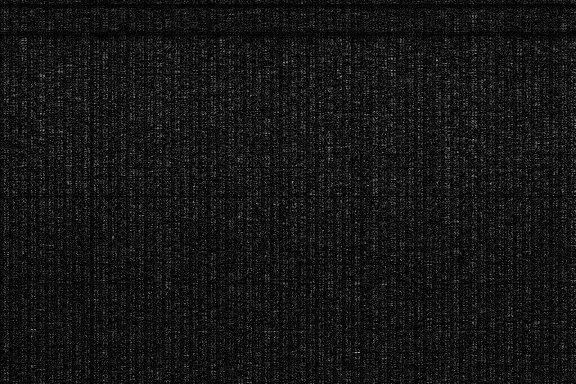

In [146]:
colorview(Gray, 3abs.(convert(Array{Float32}, w)))